In [1]:
import re
import os
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

Median radius ~ 400 nm
Ln(GSD) ~ 0.262
V ~ 24.5 um3/cc
DEHS particles (refractive index = 1.45 + 1e-5i at 532 nm)

These results are for different median size cases, namely, 200 nm, 400 nm, 600 nm and 800 nm. I included another CSV file that has the average number concentration with unit of #/cc. The GSD for these experiment are not exactly known but it is most likely between 1.05 to 1.1. Note that the unit for phase function is 1/Mm 1/str.

n addition to these narrow phase function data, I included another CSV file that has the phase function for a measurement conducted for broad size distribution with median size of 400 nm and GSD 1.4. This could already be included in the current ML model as its GSD is within the training range. Note that both phase function (P11) and polarized phase function (PPF) are include in the same csv file for the broad 400 nm data.
 
 

In [2]:
np.exp(0.262)

1.2995265424293818

# Open Data

In [3]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
directory1 = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/paper_results_gaussian_AAE/'


In [5]:
#plot_dir = directory1 + 'version13/plots/measurement_data'
#if not os.path.exists(plot_dir):
#    os.makedirs(plot_dir)



In [6]:
model_dir5 = directory1 + 'version5/model' #(P_11 and P_12)
model_dir13 = directory1  + 'version13/model' #(P_11)
model_dir19 = directory1  + 'version19/model' #(P_12)


In [7]:
model_name = 'invertible_model'
custom_objects = {'AdjustedRSquared': AdjustedRSquared}
kwargs = {'custom_objects': custom_objects,'compile': False}
surr5 = InvertibleNetworkSurrogate.load(model_dir5, model_name, model_kwargs=kwargs)
surr13 = InvertibleNetworkSurrogate.load(model_dir13, model_name, model_kwargs=kwargs)
surr19 = InvertibleNetworkSurrogate.load(model_dir19, model_name, model_kwargs=kwargs)

#Load test data

In [8]:
test_datafile5 = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'
test_datafile13 ='/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_P11_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'
test_datafile19 = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_P12_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'

qoi_test5 = pd.read_hdf(test_datafile5,key = 'qoi')
dvar_test5 = pd.read_hdf(test_datafile5,key = 'dvar')
qoi_test13 = pd.read_hdf(test_datafile13,key = 'qoi')
dvar_test13 = pd.read_hdf(test_datafile13,key = 'dvar')
qoi_test19 = pd.read_hdf(test_datafile19,key = 'qoi')
dvar_test19 = pd.read_hdf(test_datafile19,key = 'dvar')


In [9]:
train_datafile5 = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_wl-532_sc-None_qoi-ScatteringData/training_dataset.hdf5'
dvar_train5 = pd.read_hdf(train_datafile5,key = 'dvar')


In [10]:
len(dvar_train5[dvar_train5['R_median']<=0.252])

3482

In [11]:
dvar_train5.describe()

V_tot      R_median           GSD             n         k_532
count  80000.000000  80000.000000  80000.000000  80000.000000  80000.000000
mean    2502.023658      1.324777      1.424982      1.464987      0.063253
std     1441.785567      0.678175      0.014455      0.077973      0.042065
min        1.099018      0.150007      1.400000      1.330001      0.000048
25%     1255.448033      0.737128      1.412443      1.397358      0.029093
50%     2504.342367      1.324789      1.424990      1.464978      0.058281
75%     3749.541765      1.912054      1.437520      1.532521      0.089785
max     4999.961568      2.499997      1.449999      1.599998      0.199485

In [12]:
(dvar_train5[dvar_train5['V_tot']<=2.458])

V_tot  R_median       GSD         n     k_532
23882  1.588067  0.600501  1.446566  1.527140  0.046626
9320   1.121904  1.220247  1.403173  1.553898  0.070939
16085  1.533359  1.914683  1.405958  1.523145  0.015064
66522  1.966740  1.114625  1.436789  1.559314  0.089118
18234  2.172297  2.485456  1.425046  1.364514  0.092898
80838  1.631236  1.320877  1.427965  1.344809  0.049805
80168  1.855124  1.641737  1.438912  1.477362  0.058090
16586  1.785091  2.376726  1.449290  1.591660  0.081227
45916  1.467045  1.203781  1.447474  1.445468  0.033655
80289  1.099018  0.313921  1.439142  1.585064  0.077446
58363  2.332977  1.455790  1.440116  1.357689  0.045258
98230  1.425889  1.949452  1.427053  1.465007  0.070921
24897  1.807395  0.382240  1.403327  1.375701  0.036840
69725  2.258045  1.950283  1.408730  1.563539  0.023124
6786   1.657522  1.825577  1.439626  1.406134  0.028129
58933  2.378006  2.343293  1.400732  1.579706  0.000437
67285  2.437248  1.169493  1.402401  1.378588  0.067310
60526  1.746107  0.651986  1.429417  1.592957  0.011684
16011  2.062665  0.786400  1.419780  1.402354  0.023072
50969  1.236075  2.127387  1.410412  1.440514  0.094726
78537  1.176542  0.862836  1.449645  1.355960  0.056305
77240  1.365791  0.416953  1.400754  1.544654  0.053064
83555  2.222626  0.526424  1.427890  1.488054  0.105340

In [13]:
(dvar_test5[dvar_test5['V_tot']<=3])

V_tot  R_median       GSD         n     k_532
42474  2.129809  1.499424  1.430218  1.512269  0.116098
26785  1.254554  2.179194  1.431958  1.445559  0.047629
65081  2.861458  1.752558  1.431331  1.534009  0.075893
40322  1.942534  1.531211  1.441423  1.373932  0.057745
89380  2.550061  1.964920  1.439285  1.423906  0.064881
6807   2.673311  1.340034  1.408104  1.400522  0.076072
14594  1.321253  1.413391  1.402936  1.364939  0.135962
94449  1.034816  0.292959  1.444372  1.503495  0.008057
8344   2.045058  0.759491  1.403946  1.544120  0.087689

In [14]:
dvar_test5.sort_values(by=['V_tot'])

V_tot  R_median       GSD         n     k_532
94449     1.034816  0.292959  1.444372  1.503495  0.008057
26785     1.254554  2.179194  1.431958  1.445559  0.047629
14594     1.321253  1.413391  1.402936  1.364939  0.135962
40322     1.942534  1.531211  1.441423  1.373932  0.057745
8344      2.045058  0.759491  1.403946  1.544120  0.087689
...            ...       ...       ...       ...       ...
97773  4997.526722  2.419350  1.408590  1.495383  0.095786
52825  4997.641042  1.656075  1.419360  1.411678  0.061794
26464  4998.291991  2.489488  1.436877  1.451721  0.047026
61733  4998.354204  0.810506  1.417286  1.409464  0.022089
69897  4998.589326  0.505373  1.446403  1.573566  0.015382

[20000 rows x 5 columns]

Real measurement data

In [15]:
data_dir = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_Alireza_Phdthesis'

#phase_fun400_old = pd.read_csv(data_dir2+"/uNeph_PF_400nm_broad.csv")
#num_con = pd.read_csv(data_dir1+"/number_concentration.csv")
phase_fun_meas = pd.read_csv(data_dir+"/df_p11_ppf_uNeph.csv")
phase_fun_GRASP_inv = pd.read_csv(data_dir+"/df_p11_ppf_grasp.csv")
vol_size_GRASP_bin = pd.read_csv(data_dir+"/df_psd_grasp_binned.csv")
vol_size_GRASP_log = pd.read_csv(data_dir+"/df_psd_grasp_lognorm.csv")
vol_size_meas = pd.read_csv(data_dir+"/df_psd_smps.csv")
meas_param = pd.read_csv(data_dir+"/df_measured_and_retreived_psd_properties.csv")
#phase_fun400_bin = pd.read_csv(data_dir+"/df_PF_Grasp_binned_P11P12_1wl.csv")

#data_real_old = pd.read_csv(data_dir2+"/uNeph_GRASP_data.csv")

#"/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_november2021/df_PF_Grasp_binned_P11P12_1wl.csv"



#phase_fun400_log = pd.read_csv(data_dir+"/df_PF_Grasp_lognorm_P11P12_1wl.csv")

#phase_funexp = pd.read_csv(data_dir+"/phase_function_experimental_data.csv")
#phase_funP11 = pd.read_csv(data_dir+"/phase_function_P11.csv")
#phase_funpolar = pd.read_csv(data_dir+'/polar_phase_function.csv')

In [16]:
phase_fun_meas.head(12)

angles         P11       PPF
0    2.958415         NaN       NaN
1    3.939364         NaN       NaN
2    4.917770  183.301344  0.000434
3    5.893669  188.270193 -0.016319
4    6.867099  211.998636  0.017256
5    7.838099         NaN       NaN
6    8.806713         NaN       NaN
7    9.772985         NaN       NaN
8   10.736964         NaN       NaN
9   11.698698  173.001017  0.047280
10  12.658239  167.585850  0.030640
11  13.615641  165.624263  0.009350

In [17]:
phase_fun_GRASP_inv

angle  P11_Binned (0.05-15$\mu$m)_P11P12  \
0     11.698698                         184.723185   
1     12.658239                         179.542691   
2     13.615641                         174.346282   
3     16.475578                         157.690718   
4     17.424998                         151.905435   
..          ...                                ...   
151  165.388185                           2.294616   
152  166.410092                           2.346023   
153  167.435464                           2.398624   
154  168.464287                           2.451782   
155  169.496541                           2.504621   

     PPF_Binned (0.05-15$\mu$m)_P11P12  P11_Binned (0.05-15$\mu$m)_P11  \
0                             0.002964                      182.797410   
1                             0.003433                      176.351635   
2                             0.003926                      170.120719   
3                             0.005515                      151.682619   
4                             0.006071                      145.730224   
..                                 ...                             ...   
151                          -0.239340                        2.482260   
152                          -0.211780                        2.491332   
153                          -0.184640                        2.501677   
154                          -0.158310                        2.515523   
155                          -0.133180                        2.535020   

     P11_lognormal (0.05-15$\mu$m)_P11P12  \
0                              187.046847   
1                              181.643537   
2                              176.224311   
3                              158.916211   
4                              152.908112   
..                                    ...   
151                              2.304802   
152                              2.356528   
153                              2.409685   
154                              2.463639   
155                              2.517592   

     PPF_lognormal (0.05-15$\mu$m)_P11P12  P11_lognormal (0.05-15$\mu$m)_P11  
0                                0.002702                         186.227199  
1                                0.003125                         180.911424  
2                                0.003571                         175.579733  
3                                0.005000                         158.510366  
4                                0.005496                         152.581844  
..                                    ...                                ...  
151                             -0.246980                           2.299709  
152                             -0.218910                           2.351355  
153                             -0.191120                           2.404433  
154                             -0.164070                           2.458148  
155                             -0.138160                           2.511624  

[156 rows x 7 columns]

In [18]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


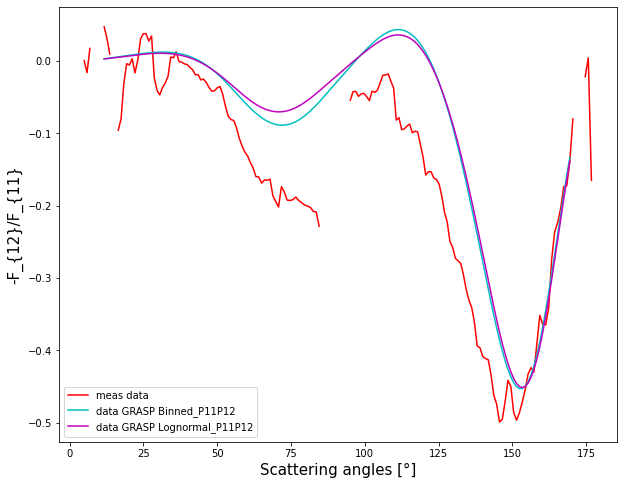

In [19]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.legend()

# transform real measurement data to right format

In [20]:
# First step: interpolate the angles

In [21]:
from scipy.interpolate import interp1d

In [22]:
phase_fun_meas['angles'].max()

176.8157278691418

In [23]:
f_11 = interp1d(phase_fun_meas['angles'],phase_fun_meas['P11'])
f_PPF = interp1d(phase_fun_meas['angles'],phase_fun_meas['PPF'])
#f_11_GRASP = interp1d(data_real['angles'],data_real['P11_GRASP_lognorm'])
#f_12_GRASP = interp1d(data_real['angles'],data_real['PPF_GRASP_lognorm'])

In [24]:
angles_meas_new = np.linspace(3,176,num = 174,endpoint = True)
angles_meas_new

array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
       135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 145.,
       146., 147., 148., 149., 150., 151., 152., 15

In [25]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
plt.plot(angles_meas_new,f_11(angles_meas_new),'b*',label = 'meas data')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


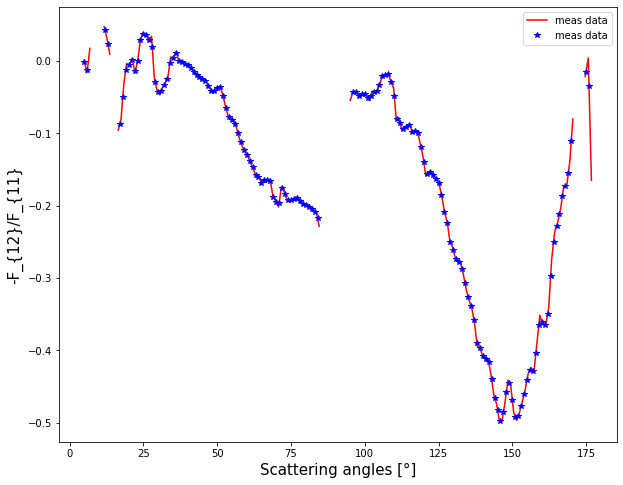

In [26]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(angles_meas_new,f_PPF(angles_meas_new),'b*',label = 'meas data')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.legend()

In [27]:
# Bringing the data in the right format

In [28]:
phase_fun_meas_form_F11 = pd.DataFrame(data = f_11(angles_meas_new)).transpose()
phase_fun_meas_form_PPF = pd.DataFrame(data = f_PPF(angles_meas_new)).transpose()


In [29]:
# Rename the columns
listindex_data1 = []
listindex_data2 = []
for i in range(len(angles_meas_new)):
    listindex_data1.append("P11_0.532_"+str(int(angles_meas_new[i])))
    listindex_data2.append("P12_0.532_"+str(int(angles_meas_new[i])))

In [30]:
listindex_data1

['P11_0.532_3',
 'P11_0.532_4',
 'P11_0.532_5',
 'P11_0.532_6',
 'P11_0.532_7',
 'P11_0.532_8',
 'P11_0.532_9',
 'P11_0.532_10',
 'P11_0.532_11',
 'P11_0.532_12',
 'P11_0.532_13',
 'P11_0.532_14',
 'P11_0.532_15',
 'P11_0.532_16',
 'P11_0.532_17',
 'P11_0.532_18',
 'P11_0.532_19',
 'P11_0.532_20',
 'P11_0.532_21',
 'P11_0.532_22',
 'P11_0.532_23',
 'P11_0.532_24',
 'P11_0.532_25',
 'P11_0.532_26',
 'P11_0.532_27',
 'P11_0.532_28',
 'P11_0.532_29',
 'P11_0.532_30',
 'P11_0.532_31',
 'P11_0.532_32',
 'P11_0.532_33',
 'P11_0.532_34',
 'P11_0.532_35',
 'P11_0.532_36',
 'P11_0.532_37',
 'P11_0.532_38',
 'P11_0.532_39',
 'P11_0.532_40',
 'P11_0.532_41',
 'P11_0.532_42',
 'P11_0.532_43',
 'P11_0.532_44',
 'P11_0.532_45',
 'P11_0.532_46',
 'P11_0.532_47',
 'P11_0.532_48',
 'P11_0.532_49',
 'P11_0.532_50',
 'P11_0.532_51',
 'P11_0.532_52',
 'P11_0.532_53',
 'P11_0.532_54',
 'P11_0.532_55',
 'P11_0.532_56',
 'P11_0.532_57',
 'P11_0.532_58',
 'P11_0.532_59',
 'P11_0.532_60',
 'P11_0.532_61',
 'P1

In [31]:
phase_fun_meas

angles         P11       PPF
0      2.958415         NaN       NaN
1      3.939364         NaN       NaN
2      4.917770  183.301344  0.000434
3      5.893669  188.270193 -0.016319
4      6.867099  211.998636  0.017256
..          ...         ...       ...
170  172.613621         NaN       NaN
171  173.659308         NaN       NaN
172  174.708254    3.704716 -0.021855
173  175.760413    4.199440  0.004090
174  176.815728    5.250858 -0.165046

[175 rows x 3 columns]

In [32]:
dicts_data_1 = {}
j = 0
for i in phase_fun_meas_form_F11.columns:
    dicts_data_1[i]=listindex_data1[j]
    j=j+1
dicts_data_2 = {}
j = 0
for i in phase_fun_meas_form_PPF.columns:
    dicts_data_2[i]=listindex_data2[j]
    j=j+1

In [33]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.rename(dicts_data_1, axis =1)
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.rename(dicts_data_2, axis =1)

In [34]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.rename({"P11":'0'},axis=0)
phase_fun_meas_form_PPF= phase_fun_meas_form_PPF.rename({"PPF":'0'},axis=0)


In [35]:
phase_fun_meas_form_PPF

P12_0.532_3  P12_0.532_4  P12_0.532_5  P12_0.532_6  P12_0.532_7  \
0          NaN          NaN    -0.000978    -0.012651          NaN   

   P12_0.532_8  P12_0.532_9  P12_0.532_10  P12_0.532_11  P12_0.532_12  ...  \
0          NaN          NaN           NaN           NaN      0.042055  ...   

   P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  P12_0.532_171  \
0      -0.186467      -0.173068      -0.155111      -0.110407            NaN   

   P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  P12_0.532_176  
0            NaN            NaN            NaN      -0.014661      -0.034309  

[1 rows x 174 columns]

In [36]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.drop(['P11_0.532_3','P11_0.532_4','P11_0.532_176'], axis = 1)

In [37]:
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.drop(['P12_0.532_3','P12_0.532_4','P12_0.532_176'], axis = 1)


In [38]:
# add the missing points

In [39]:
phase_fun_meas_form_F11['P11_0.532_9']=(phase_fun_meas_form_F11['P11_0.532_12']+phase_fun_meas_form_F11['P11_0.532_6'])/2.
phase_fun_meas_form_F11['P11_0.532_8']=(phase_fun_meas_form_F11['P11_0.532_6']+2*phase_fun_meas_form_F11['P11_0.532_9'])/3.
phase_fun_meas_form_F11['P11_0.532_7']=(2*phase_fun_meas_form_F11['P11_0.532_6']+phase_fun_meas_form_F11['P11_0.532_9'])/3.
phase_fun_meas_form_F11['P11_0.532_10']=(2*phase_fun_meas_form_F11['P11_0.532_9']+phase_fun_meas_form_F11['P11_0.532_12'])/3.
phase_fun_meas_form_F11['P11_0.532_11']=(phase_fun_meas_form_F11['P11_0.532_9']+2*phase_fun_meas_form_F11['P11_0.532_12'])/3.

phase_fun_meas_form_F11['P11_0.532_171']=(4*phase_fun_meas_form_F11['P11_0.532_170']+phase_fun_meas_form_F11['P11_0.532_175'])/5.
phase_fun_meas_form_F11['P11_0.532_172']=(3*phase_fun_meas_form_F11['P11_0.532_170']+2*phase_fun_meas_form_F11['P11_0.532_175'])/5.
phase_fun_meas_form_F11['P11_0.532_173']=(3*phase_fun_meas_form_F11['P11_0.532_170']+3*phase_fun_meas_form_F11['P11_0.532_175'])/5.
phase_fun_meas_form_F11['P11_0.532_174']=(phase_fun_meas_form_F11['P11_0.532_170']+4*phase_fun_meas_form_F11['P11_0.532_175'])/5.





In [40]:
phase_fun_meas_form_PPF['P12_0.532_9']=(phase_fun_meas_form_PPF['P12_0.532_12']+phase_fun_meas_form_PPF['P12_0.532_6'])/2.
phase_fun_meas_form_PPF['P12_0.532_8']=(phase_fun_meas_form_PPF['P12_0.532_6']+2*phase_fun_meas_form_PPF['P12_0.532_9'])/3.
phase_fun_meas_form_PPF['P12_0.532_7']=(2*phase_fun_meas_form_PPF['P12_0.532_6']+phase_fun_meas_form_PPF['P12_0.532_9'])/3.
phase_fun_meas_form_PPF['P12_0.532_10']=(2*phase_fun_meas_form_PPF['P12_0.532_9']+phase_fun_meas_form_PPF['P12_0.532_12'])/3.
phase_fun_meas_form_PPF['P12_0.532_11']=(phase_fun_meas_form_PPF['P12_0.532_9']+2*phase_fun_meas_form_PPF['P12_0.532_12'])/3.

phase_fun_meas_form_PPF['P12_0.532_171']=(4*phase_fun_meas_form_PPF['P12_0.532_170']+phase_fun_meas_form_PPF['P12_0.532_175'])/5.
phase_fun_meas_form_PPF['P12_0.532_172']=(3*phase_fun_meas_form_PPF['P12_0.532_170']+2*phase_fun_meas_form_PPF['P12_0.532_175'])/5.
phase_fun_meas_form_PPF['P12_0.532_173']=(3*phase_fun_meas_form_PPF['P12_0.532_170']+3*phase_fun_meas_form_PPF['P12_0.532_175'])/5.
phase_fun_meas_form_PPF['P12_0.532_174']=(phase_fun_meas_form_PPF['P12_0.532_170']+4*phase_fun_meas_form_PPF['P12_0.532_175'])/5.





In [41]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.drop(['P11_0.532_85','P11_0.532_86','P11_0.532_87','P11_0.532_88','P11_0.532_89','P11_0.532_90','P11_0.532_91','P11_0.532_92','P11_0.532_93','P11_0.532_94','P11_0.532_95'],axis =1)


In [42]:
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.drop(['P12_0.532_85','P12_0.532_86','P12_0.532_87','P12_0.532_88','P12_0.532_89','P12_0.532_90','P12_0.532_91','P12_0.532_92','P12_0.532_93','P12_0.532_94','P12_0.532_95'],axis =1)


In [43]:
phase_fun_meas_form_F11['P11_0.532_14']=(3*phase_fun_meas_form_F11['P11_0.532_13']+phase_fun_meas_form_F11['P11_0.532_17'])/4.
phase_fun_meas_form_F11['P11_0.532_15']=(phase_fun_meas_form_F11['P11_0.532_13']+phase_fun_meas_form_F11['P11_0.532_17'])/2.
phase_fun_meas_form_F11['P11_0.532_16']=(phase_fun_meas_form_F11['P11_0.532_13']+3*phase_fun_meas_form_F11['P11_0.532_17'])/4.


In [44]:
phase_fun_meas_form_PPF['P12_0.532_14']=(3*phase_fun_meas_form_PPF['P12_0.532_13']+phase_fun_meas_form_PPF['P12_0.532_17'])/4.
phase_fun_meas_form_PPF['P12_0.532_15']=(phase_fun_meas_form_PPF['P12_0.532_13']+phase_fun_meas_form_PPF['P12_0.532_17'])/2.
phase_fun_meas_form_PPF['P12_0.532_16']=(phase_fun_meas_form_PPF['P12_0.532_13']+3*phase_fun_meas_form_PPF['P12_0.532_17'])/4.


In [45]:
phase_fun_meas_form_PPF.isnull()

P12_0.532_5  P12_0.532_6  P12_0.532_7  P12_0.532_8  P12_0.532_9  \
0        False        False        False        False        False   

   P12_0.532_10  P12_0.532_11  P12_0.532_12  P12_0.532_13  P12_0.532_14  ...  \
0         False         False         False         False         False  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0          False          False          False          False          False   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0          False          False          False          False          False  

[1 rows x 160 columns]

In [46]:
# create vector with angles according to NN
angles_NN_1 = np.arange(5,85)
angles_NN_2 = np.arange(96, 176)
angles_NN = np.concatenate((angles_NN_1.T, angles_NN_2.T))
angles_NN

array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175])

In [47]:
len(angles_NN)

160

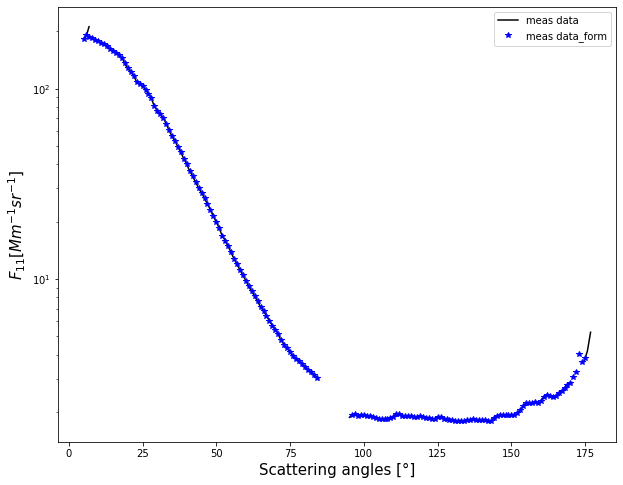

In [48]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
#plt.plot(angles_meas_new,f_11(angles_meas_new),'b*',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_F11.loc[0],'b*',label = 'meas data_form')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


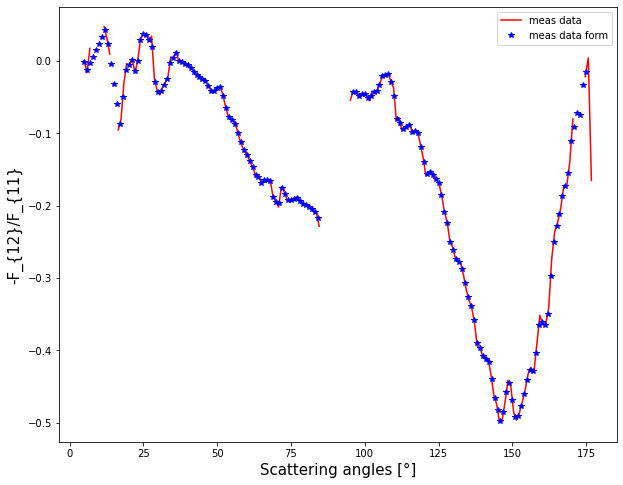

In [49]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_PPF.loc[0],'b*',label = 'meas data form')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.legend()

In [50]:
P11_column_names = list(filter(re.compile(".*P11").match, qoi_test5.columns))
P12_column_names = list(filter(re.compile(".*P12").match, qoi_test5.columns))
P11_column_names

['P11_0.532_5',
 'P11_0.532_6',
 'P11_0.532_7',
 'P11_0.532_8',
 'P11_0.532_9',
 'P11_0.532_10',
 'P11_0.532_11',
 'P11_0.532_12',
 'P11_0.532_13',
 'P11_0.532_14',
 'P11_0.532_15',
 'P11_0.532_16',
 'P11_0.532_17',
 'P11_0.532_18',
 'P11_0.532_19',
 'P11_0.532_20',
 'P11_0.532_21',
 'P11_0.532_22',
 'P11_0.532_23',
 'P11_0.532_24',
 'P11_0.532_25',
 'P11_0.532_26',
 'P11_0.532_27',
 'P11_0.532_28',
 'P11_0.532_29',
 'P11_0.532_30',
 'P11_0.532_31',
 'P11_0.532_32',
 'P11_0.532_33',
 'P11_0.532_34',
 'P11_0.532_35',
 'P11_0.532_36',
 'P11_0.532_37',
 'P11_0.532_38',
 'P11_0.532_39',
 'P11_0.532_40',
 'P11_0.532_41',
 'P11_0.532_42',
 'P11_0.532_43',
 'P11_0.532_44',
 'P11_0.532_45',
 'P11_0.532_46',
 'P11_0.532_47',
 'P11_0.532_48',
 'P11_0.532_49',
 'P11_0.532_50',
 'P11_0.532_51',
 'P11_0.532_52',
 'P11_0.532_53',
 'P11_0.532_54',
 'P11_0.532_55',
 'P11_0.532_56',
 'P11_0.532_57',
 'P11_0.532_58',
 'P11_0.532_59',
 'P11_0.532_60',
 'P11_0.532_61',
 'P11_0.532_62',
 'P11_0.532_63',
 '

In [51]:
# prepare the dataframes for retrieval with the different methods
phase400new5 = pd.concat([np.log(phase_fun_meas_form_F11*1e-12),phase_fun_meas_form_PPF],axis =1)
phase400new13 = np.log(phase_fun_meas_form_F11*1e-12)
phase400new19 = phase_fun_meas_form_PPF

In [52]:
phase400new5

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0   -22.417608    -22.37947   -22.396699    -22.41423   -22.432075   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0    -22.450243    -22.468748    -22.487601    -22.513712    -22.539139  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0       -0.21156      -0.186467      -0.173068      -0.155111      -0.110407   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0      -0.091258      -0.072109      -0.075041       -0.03381      -0.014661  

[1 rows x 320 columns]

# Predict dvar from measurement data

In [53]:
#P11, PPF

dvar_pred_iv5 = surr5.sample_n_tries(phase400new5.values, batch_size=128, n_tries=32)
# OnlyP11 
dvar_pred_iv13 = surr13.sample_n_tries(phase400new13.values, batch_size=128, n_tries=32)
# Only PPF
dvar_pred_iv19 = surr19.sample_n_tries(phase400new19.values, batch_size=128, n_tries=32)


In [83]:
# only P11 
dvar_pred_iv13 = pd.DataFrame(data=dvar_pred_iv13, columns=dvar_test5.columns)
dvar_pred_iv13

V_tot  R_median       GSD         n     k_532
0  11.251791  0.489793  1.427493  1.372477  0.028972

In [55]:
# P11,PPF
dvar_pred_iv5 = pd.DataFrame(data=dvar_pred_iv5, columns=dvar_test5.columns)
dvar_pred_iv5

V_tot  R_median       GSD         n     k_532
0  223.256851  1.529651  1.445211  1.492548  0.034713

In [56]:
# only PPF
dvar_pred_iv19 = pd.DataFrame(data=dvar_pred_iv19, columns=dvar_test19.columns)
dvar_pred_iv19

V_tot  R_median       GSD         n     k_532
0  7464.651977  0.085006  1.438351  1.546773 -0.105286

# Compare to true values

In [57]:
dvar_pred_iv13['R_median'].values[0]

0.48979307559616386

In [58]:
meas_param

Unnamed: 0    CMR    GSD  V_tot
0                              SMPS  0.252  1.419  2.458
1     Binned (0.05-15$\mu$m)_P11P12  0.275  1.293  2.081
2        Binned (0.05-15$\mu$m)_P11  0.299  1.548  2.296
3  lognormal (0.05-15$\mu$m)_P11P12  0.276  1.321  2.101
4     lognormal (0.05-15$\mu$m)_P11  0.275  1.313  2.096

In [59]:
meas_param.loc[5]=["INN_P11", dvar_pred_iv13['R_median'].values[0],dvar_pred_iv13['GSD'].values[0],dvar_pred_iv13['V_tot'].values[0]]
meas_param.loc[6]=["INN_P11PPF", dvar_pred_iv5['R_median'].values[0],dvar_pred_iv5['GSD'].values[0],dvar_pred_iv5['V_tot'].values[0]]
meas_param.loc[7]=["INN_P12", dvar_pred_iv19['R_median'].values[0],dvar_pred_iv19['GSD'].values[0],dvar_pred_iv19['V_tot'].values[0]]


In [60]:
meas_param['n'] = [1.455,1.444,1.431,1.442,1.443, dvar_pred_iv13['n'].values[0],dvar_pred_iv5['n'].values[0],dvar_pred_iv19['n'].values[0]]

meas_param['k_532'] = [0,0.00004,0.000011,0.00045,0.00016, dvar_pred_iv13['k_532'].values[0],dvar_pred_iv5['k_532'].values[0],dvar_pred_iv19['k_532'].values[0]]



In [61]:
meas_param

Unnamed: 0       CMR       GSD        V_tot  \
0                              SMPS  0.252000  1.419000     2.458000   
1     Binned (0.05-15$\mu$m)_P11P12  0.275000  1.293000     2.081000   
2        Binned (0.05-15$\mu$m)_P11  0.299000  1.548000     2.296000   
3  lognormal (0.05-15$\mu$m)_P11P12  0.276000  1.321000     2.101000   
4     lognormal (0.05-15$\mu$m)_P11  0.275000  1.313000     2.096000   
5                           INN_P11  0.489793  1.427493    11.251791   
6                        INN_P11PPF  1.529651  1.445211   223.256851   
7                           INN_P12  0.085006  1.438351  7464.651977   

          n     k_532  
0  1.455000  0.000000  
1  1.444000  0.000040  
2  1.431000  0.000011  
3  1.442000  0.000450  
4  1.443000  0.000160  
5  1.372477  0.028972  
6  1.492548  0.034713  
7  1.546773 -0.105286

In [62]:
meas_param_summary = meas_param.drop('Unnamed: 0', axis = 1)

# Recompute phase functions

In [63]:
param_meas_data = meas_param.iloc[0]

In [64]:
meas_param_summary =meas_param_summary.rename({'CMR':'R_median'}, axis =1)
meas_param_summary 

R_median       GSD        V_tot         n     k_532
0  0.252000  1.419000     2.458000  1.455000  0.000000
1  0.275000  1.293000     2.081000  1.444000  0.000040
2  0.299000  1.548000     2.296000  1.431000  0.000011
3  0.276000  1.321000     2.101000  1.442000  0.000450
4  0.275000  1.313000     2.096000  1.443000  0.000160
5  0.489793  1.427493    11.251791  1.372477  0.028972
6  1.529651  1.445211   223.256851  1.492548  0.034713
7  0.085006  1.438351  7464.651977  1.546773 -0.105286

In [65]:
dvar_pred_iv5

V_tot  R_median       GSD         n     k_532
0  223.256851  1.529651  1.445211  1.492548  0.034713

In [66]:
first_column = meas_param_summary.pop('V_tot')

meas_param_summary.insert(0, 'V_tot', first_column)
 


In [67]:
pd.DataFrame(meas_param_summary.iloc[0]).T 

V_tot  R_median    GSD      n  k_532
0  2.458     0.252  1.419  1.455    0.0

In [68]:
qoi_pred_iv_meas13_real = surr13.predict(pd.DataFrame(meas_param_summary.iloc[0]).T  )
qoi_pred_iv_meas13_real =pd.DataFrame(qoi_pred_iv_meas13_real,columns= qoi_test13.columns)

qoi_pred_iv_meas5_real = surr5.predict(pd.DataFrame(meas_param_summary.iloc[0]).T  )
qoi_pred_iv_meas5_real =pd.DataFrame(qoi_pred_iv_meas5_real,columns= qoi_test5.columns)


qoi_pred_iv_meas5 = surr5.predict(dvar_pred_iv5)
qoi_pred_iv_meas5 =pd.DataFrame(qoi_pred_iv_meas5,columns= qoi_test5.columns)

qoi_pred_iv_meas13 = surr13.predict(dvar_pred_iv13)
qoi_pred_iv_meas13 =pd.DataFrame(qoi_pred_iv_meas13,columns= qoi_test13.columns)

qoi_pred_iv_meas19 = surr19.predict(dvar_pred_iv19)
qoi_pred_iv_meas19 =pd.DataFrame(qoi_pred_iv_meas19,columns= qoi_test19.columns)


In [84]:
qoi_pred_iv_meas5_new = surr5.predict(dvar_pred_iv13)
qoi_pred_iv_meas5_new =pd.DataFrame(qoi_pred_iv_meas5_new,columns= qoi_test5.columns)


In [69]:
qoi_pred_iv_meas13_real

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0   -21.324143    -21.60867   -21.417381    -21.46192   -21.448453   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0    -21.549428    -21.473702    -21.628862    -21.582313    -21.634126  ...   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  \
0     -25.694517     -25.575642     -25.333255     -25.813922     -25.557612   

   P11_0.532_171  P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  
0     -25.935518     -25.593291     -25.791387     -25.570701     -25.537661  

[1 rows x 160 columns]

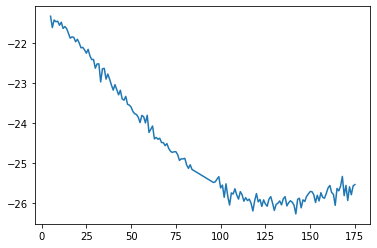

In [70]:
plt.plot(angles_NN,qoi_pred_iv_meas13_real.loc[0],label='INN_P11P12 with meas param' )


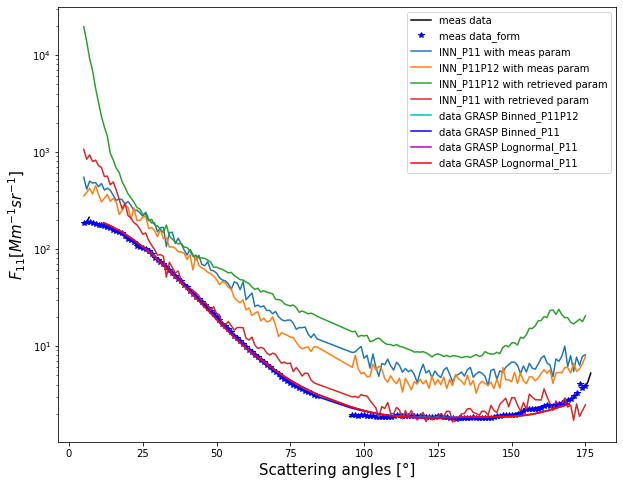

In [71]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
#plt.plot(angles_meas_new,f_11(angles_meas_new),'b*',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_F11.loc[0],'b*',label = 'meas data_form')
plt.plot(angles_NN,np.exp(qoi_pred_iv_meas13_real.loc[0])*1e+12,label='INN_P11 with meas param' )
plt.plot(angles_NN,np.exp(qoi_pred_iv_meas5_real[P11_column_names].loc[0])*1e+12,label='INN_P11P12 with meas param' )

plt.plot(angles_NN,np.exp(qoi_pred_iv_meas5[P11_column_names].loc[0])*1e+12,label='INN_P11P12 with retrieved param' )
plt.plot(angles_NN,np.exp(qoi_pred_iv_meas13[P11_column_names].loc[0])*1e+12,label='INN_P11 with retrieved param' )

plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


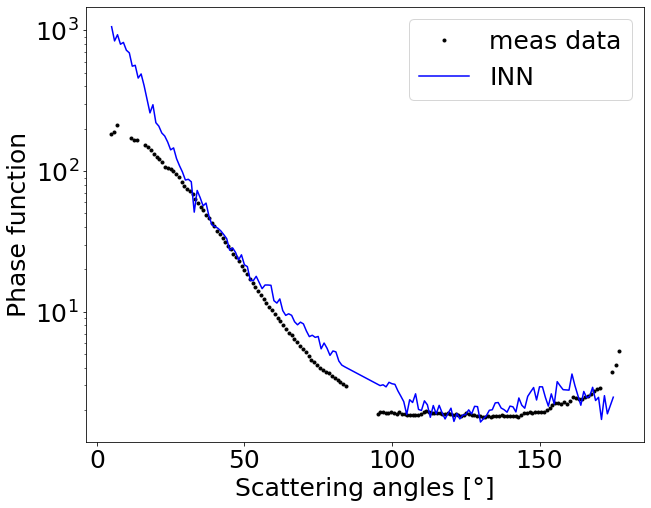

In [82]:
fontsize1 = 25
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'.k',label = 'meas data')
#plt.plot(angles_meas_new,f_11(angles_meas_new),'b*',label = 'meas data')
#plt.plot(angles_NN,phase_fun_meas_form_F11.loc[0],'b*',label = 'meas data_form')
#plt.plot(angles_NN,np.exp(qoi_pred_iv_meas13_real.loc[0])*1e+12,label='INN_P11 with meas param' )
#plt.plot(angles_NN,np.exp(qoi_pred_iv_meas5_real[P11_column_names].loc[0])*1e+12,label='INN_P11P12 with meas param' )

#plt.plot(angles_NN,np.exp(qoi_pred_iv_meas5[P11_column_names].loc[0])*1e+12,label='INN_P11P12 with retrieved param' )
plt.plot(angles_NN,np.exp(qoi_pred_iv_meas13[P11_column_names].loc[0])*1e+12,color = 'blue',label='INN' )

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('Phase function', fontsize = fontsize1)
plt.legend(fontsize = fontsize1)
plt.tick_params(axis='both', which='major', labelsize=fontsize1)

In [72]:
np.max(phase_fun_meas_form_F11.loc[0])

190.86212113482443

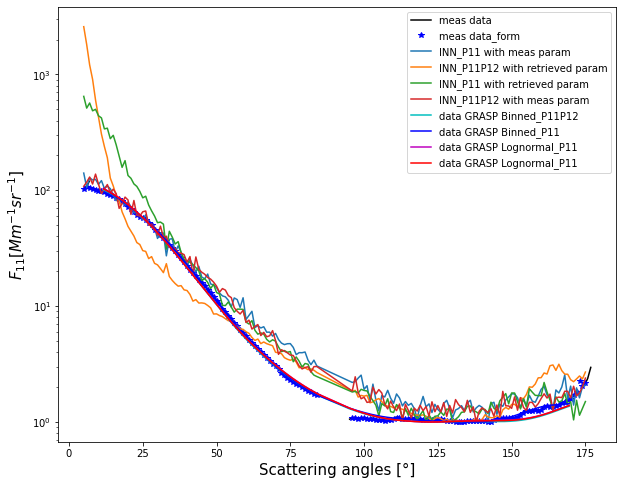

In [73]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11']/np.min(phase_fun_meas['P11']),'k',label = 'meas data')
#plt.plot(angles_meas_new,f_11(angles_meas_new),'b*',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_F11.loc[0]/np.min(phase_fun_meas_form_F11.loc[0]),'b*',label = 'meas data_form')
plt.plot(angles_NN,np.exp(qoi_pred_iv_meas13_real.loc[0])*1e+12/np.min(np.exp(qoi_pred_iv_meas13_real.loc[0])*1e+12),label='INN_P11 with meas param' )

plt.plot(angles_NN,np.exp(qoi_pred_iv_meas5[P11_column_names].loc[0])*1e+12/np.min(np.exp(qoi_pred_iv_meas5[P11_column_names].loc[0])*1e+12),label='INN_P11P12 with retrieved param' )
plt.plot(angles_NN,np.exp(qoi_pred_iv_meas13[P11_column_names].loc[0])*1e+12/np.min(np.exp(qoi_pred_iv_meas13[P11_column_names].loc[0])*1e+12),label='INN_P11 with retrieved param' )
plt.plot(angles_NN,np.exp(qoi_pred_iv_meas5_real[P11_column_names].loc[0])*1e+12/np.min(np.exp(qoi_pred_iv_meas5_real[P11_column_names].loc[0])*1e+12),label='INN_P11P12 with meas param' )


plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12']/np.min(phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12']),'c',label = 'data GRASP Binned_P11P12')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11']/np.min(phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11']),'b',label = 'data GRASP Binned_P11')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12']/np.min(phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12']),'m',label = 'data GRASP Lognormal_P11')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11']/np.min(phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11']),'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


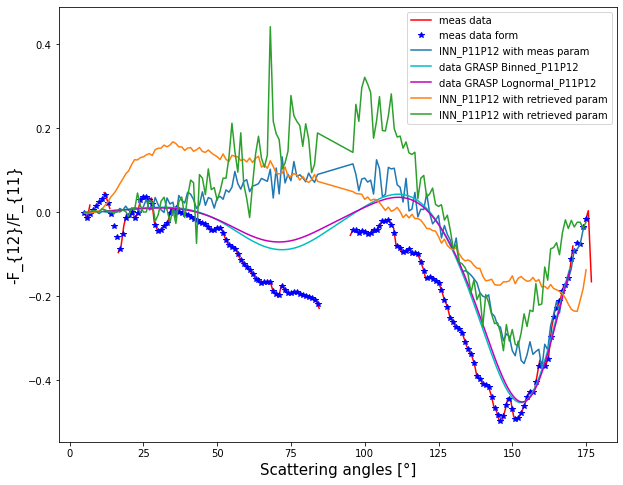

In [92]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_PPF.loc[0],'b*',label = 'meas data form')
plt.plot(angles_NN,(qoi_pred_iv_meas5_real[P12_column_names].loc[0]),label='INN_P11P12 with meas param' )


plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')
plt.plot(angles_NN,(qoi_pred_iv_meas5[P12_column_names].loc[0]),label='INN_P11P12 with retrieved param' )
plt.plot(angles_NN,(qoi_pred_iv_meas19[P12_column_names].loc[0]),label='INN_P11P12 with retrieved param' )


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.legend()


In [94]:
fontsize1 = 25
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'k.',label = 'meas data')
#plt.plot(angles_NN,phase_fun_meas_form_PPF.loc[0],'b*',label = 'meas data form')
#plt.plot(angles_NN,(qoi_pred_iv_meas5_real[P12_column_names].loc[0]),label='INN_P11P12 with meas param' )


#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')
#plt.plot(angles_NN,qoi_pred_iv_meas5_new[P12_column_names].loc[0],color = 'blue',label='INN_P11P12 with retrieved param' )
plt.plot(angles_NN,(qoi_pred_iv_meas19[P12_column_names].loc[0]), color = 'blue',label='INN' )
#plt.plot(angles_NN,(qoi_pred_iv_meas5[P12_column_names].loc[0]), color = 'orange',label='INN_P11P12 with retrieved param' )


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('polarized phase function', fontsize = fontsize1)
plt.legend(fontsize = fontsize1)
plt.tick_params(axis='both', which='major', labelsize=fontsize1)

In [71]:

# Plot volume size distribution

In [72]:
vol_size_GRASP_bin

r (um)  Binned (0.05-15$\mu$m)_P11P12  Binned (0.05-15$\mu$m)_P11
0    0.050000                   2.315996e-26                9.161790e-27
1    0.065604                   5.022233e-18                3.085720e-19
2    0.086077                   2.703889e-11                1.165868e-12
3    0.112940                   3.691372e-06                2.603947e-07
4    0.148180                   1.383043e-02                2.835080e-03
5    0.194430                   1.712619e+00                1.125214e+00
6    0.255100                   9.931860e+00                1.203298e+01
7    0.334720                   5.407010e+00                3.399220e+00
8    0.439170                   5.723266e-01                5.983447e-01
9    0.576230                   4.302895e-03                1.306863e+00
10   0.756050                   2.585628e-06                9.472645e-01
11   0.992000                   2.842514e-10                5.159362e-02
12   1.301600                   1.750762e-14                6.272099e-05
13   1.707800                   1.795756e-18                4.144851e-09
14   2.240700                   7.214938e-22                9.252720e-14
15   2.940000                   1.936825e-24                4.490704e-18
16   3.857500                   4.348800e-26                1.841345e-21
17   5.061300                   9.161825e-27                1.263301e-23
18   6.640700                   1.112069e-26                1.646585e-24
19   8.713100                   9.640042e-26                3.454677e-24
20  11.432000                   4.784370e-24                9.550888e-23
21  15.000000                   1.308819e-21                3.165337e-20

In [73]:
r_vol = np.linspace(0.05,5, 500)


In [74]:
meas_param_summary 

V_tot  R_median       GSD         n     k_532
0     2.458000  0.252000  1.419000  1.455000  0.000000
1     2.081000  0.275000  1.293000  1.444000  0.000040
2     2.296000  0.299000  1.548000  1.431000  0.000011
3     2.101000  0.276000  1.321000  1.442000  0.000450
4     2.096000  0.275000  1.313000  1.443000  0.000160
5    11.251791  0.489793  1.427493  1.372477  0.028972
6   223.256851  1.529651  1.445211  1.492548  0.034713
7  7464.651977  0.085006  1.438351  1.546773 -0.105286

In [75]:
def pdf(Vtot, x, mu, sigma):
    return Vtot/(np.sqrt(2*np.pi)*np.log(sigma))*np.exp(-(np.log(x)-np.log(mu))**2.0/(2*(np.log(sigma))**2.0))

In [76]:
meas_param_summary

V_tot  R_median       GSD         n     k_532
0     2.458000  0.252000  1.419000  1.455000  0.000000
1     2.081000  0.275000  1.293000  1.444000  0.000040
2     2.296000  0.299000  1.548000  1.431000  0.000011
3     2.101000  0.276000  1.321000  1.442000  0.000450
4     2.096000  0.275000  1.313000  1.443000  0.000160
5    11.251791  0.489793  1.427493  1.372477  0.028972
6   223.256851  1.529651  1.445211  1.492548  0.034713
7  7464.651977  0.085006  1.438351  1.546773 -0.105286

In [77]:
i =0
vol_size_dvar5_real = pdf(meas_param_summary['V_tot'].iloc[i],r_vol, meas_param_summary['R_median'].iloc[i],meas_param_summary['GSD'].iloc[i])
i = 3
vol_size_GRASP_P11P12_log = pdf(meas_param_summary['V_tot'].iloc[i],r_vol, meas_param_summary['R_median'].iloc[i],meas_param_summary['GSD'].iloc[i])
i = 5
vol_size_P11P12_INN = pdf(meas_param_summary['V_tot'].iloc[i],r_vol, meas_param_summary['R_median'].iloc[i],meas_param_summary['GSD'].iloc[i])
i=6
vol_size_P11_INN = pdf(meas_param_summary['V_tot'].iloc[i],r_vol, meas_param_summary['R_median'].iloc[i],meas_param_summary['GSD'].iloc[i])

i=7
vol_size_P12_INN = pdf(meas_param_summary['V_tot'].iloc[i],r_vol, meas_param_summary['R_median'].iloc[i],meas_param_summary['GSD'].iloc[i])


In [78]:
vol_size_meas.columns

Index(['r (um)', 'dV/dlogr'], dtype='object')

In [83]:
figure, ax = plt.subplots(1,1, figsize = [15, 10])
ax.plot(vol_size_GRASP_log['r (um)'],vol_size_GRASP_log['lognormal (0.05-15$\mu$m)_P11P12'], label = 'GRASP log P11P12')
ax.plot(vol_size_GRASP_log['r (um)'],vol_size_GRASP_log['lognormal (0.05-15$\mu$m)_P11'], label = 'GRASP log P11P12')

ax.plot(r_vol,vol_size_dvar5_real, label='computed with real meas value' )
ax.plot(r_vol,vol_size_GRASP_P11P12_log, label='computed with GRASP_P11P12_log' )
ax.plot(r_vol,vol_size_P11P12_INN, label='computed with rP11P12_INN' )
#ax.plot(r_vol,vol_size_P11_INN, label='computed with P11_INN' )
#ax.plot(r_vol,vol_size_P12_INN, label='computed with P12_INN' )




ax.plot(vol_size_meas['r (um)'], vol_size_meas['dV/dlogr'], label="meas SMPS")






ax.set_xlim([0.001, 10])
ax.set_xscale('log')
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
ax.grid(b=True, which = 'major', linewidth = 0.75)
ax.grid(b=True, which = 'minor', linewidth = 0.25)    

ax.legend(ncol = 1, loc = 'upper left')#, bbox_to_anchor = (1,1.15), fontsize = 12)
ax.set_xlabel('radius')
ax.set_ylabel('volume size distribution')

ax.set_title('$v=Vtot/(\sqrt{2\pi}\log(\sigma))*\exp{[-(\log(x)-\log(\mu))^2/(2(\log(\sigma))^2)]}$')





Text(0.5, 1.0, '$v=Vtot/(\\sqrt{2\\pi}\\log(\\sigma))*\\exp{[-(\\log(x)-\\log(\\mu))^2/(2(\\log(\\sigma))^2)]}$')